In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from keras.callbacks import EarlyStopping
# To control learning rate:
from keras import backend as K
import h5py

print("Using version {} of Keras.".format(keras.__version__))

import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import OrderedDict


from pandas import DataFrame, plotting

import matplotlib.colors as colors
cmap = 'rainbow'

Using TensorFlow backend.


Using version 2.2.4 of Keras.


In [2]:
# Load dataset

    # classifier dataset, constructed by randomly choosing three
    # incorrect b pairs to match the number of incorrect b pairs.
# dataset = np.load('6b_Datasets/MX700_MY400_random_bpairs_ptetaphimDetaDphi_binary_dataset.npz') 
dataset = np.load('nn_input_MX700_MY400_classifier.npz')
    
    # regression dataset
# dataset = np.load('6b_Datasets/MX700_MY400_Yreg_dataset.npz')



# Define output
y = dataset['y']
Higgs_pair_mask = y == 1

# Define parameters
X = dataset['x']
X = X[Higgs_pair_mask]

# Used to compare score with dijet invariant mass
mjj = dataset['mjj'] # GeV
y = mjj[Higgs_pair_mask]**2
y_norm_factor = np.max(y)
# y_norm_factor = 1
y = y/y_norm_factor

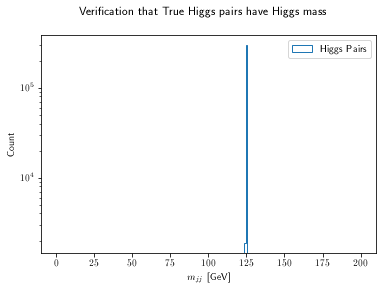

In [3]:
Higgs_mask = y == 1
fig, axs = plt.subplots(nrows=1, ncols=1)
fig.suptitle("Verification that True Higgs pairs have Higgs mass")

ax = axs
# ax.set_title("Verification that True Higgs pairs have Higgs mass")
bins = np.linspace(0,  200, 200)
n, bins, _ = ax.hist(np.sqrt(y*y_norm_factor), histtype='step', align='mid', bins=bins, label='Higgs Pairs')
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'$m_{jj}$ [GeV]')
ax.legend()

In [4]:
xscaler = MinMaxScaler()
xscaler.fit(X)
xnormalized = xscaler.transform(X)
xinverse = xscaler.inverse_transform(xnormalized)

test_size = 0.20
val_size = 0.125
# Split dataset into training and test sets. Test set is 20% of total dataset, training set is 80% of total dataset.
x_train, x_test, y_train, y_test = train_test_split(xnormalized, y, test_size=test_size, random_state=42)
# Split training dataset into training set and validation set. Validation set is 12.5% of initial training set and new training set is 87.5% of initial training set (87.5% of 80% is 70%)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42)

print("Training set:   ", len(x_train))
print("Validation set: ", len(x_val))
print("Testing set:    ", len(x_test))

param_dim = np.shape(x_train)[1]
print("Input parameters:",param_dim) # Use this as a guide for how many nodes to use in hidden layers

Training set:    210000
Validation set:  30000
Testing set:     60000
Input parameters: 7


In [5]:
# define the keras model
model = Sequential()

# Input layers
input_activation = 'selu'
input_nodes = 7
model.add(Dense(input_nodes, input_dim=param_dim, activation=input_activation))

# Hidden layers
nodes = [64,64,128,128,64]
hidden_activations = ['selu'] * len(nodes)
assert(len(nodes) == len(hidden_activations))
num_hidden = len(nodes)
for i in range(num_hidden):
    model.add(Dense(nodes[i], activation=hidden_activations[i]))

# Output layer
output_activation = 'linear'
output_nodes = 1
model.add(Dense(output_nodes, activation=output_activation))

W0115 05:48:38.116342 140075689846592 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0115 05:48:38.158049 140075689846592 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0115 05:48:38.164903 140075689846592 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0115 05:48:38.203065 140075689846592 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64

In [6]:
# optimizer = keras.optimizers.Adam(lr=0.0001)
# optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.7, beta_2=0.3, epsilon=0.1)
optimizer = keras.optimizers.Nadam()

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

lr_metric = get_lr_metric(optimizer)

es = EarlyStopping(monitor='loss', restore_best_weights=True)

loss = 'mse'

def percentage_difference(y_true, y_pred):
    return K.mean(abs(y_pred/y_true - 1) * 100)

model.compile(loss=loss, optimizer=optimizer, metrics=['mean_squared_error',lr_metric, percentage_difference])

W0115 05:48:38.417462 140075689846592 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [7]:
# fit the keras model on the dataset
num_epochs = 100
num_batch_size = 500
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, batch_size=num_batch_size, callbacks=[es])

W0115 05:48:39.629176 140075689846592 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0115 05:48:39.871344 140075689846592 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 210000 samples, validate on 30000 samples
Epoch 1/100
210000/210000 [==============================] - 10s 46us/step - loss: 0.0261 - mean_squared_error: 0.0261 - lr: 0.0020 - percentage_difference: 7.2188 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_lr: 0.0020 - val_percentage_difference: 5.4062
Epoch 2/100
210000/210000 [==============================] - 9s 42us/step - loss: 0.0015 - mean_squared_error: 0.0015 - lr: 0.0020 - percentage_difference: 3.2493 - val_loss: 9.1437e-04 - val_mean_squared_error: 9.1437e-04 - val_lr: 0.0020 - val_percentage_difference: 2.6473
Epoch 3/100
210000/210000 [==============================] - 9s 41us/step - loss: 6.3747e-04 - mean_squared_error: 6.3747e-04 - lr: 0.0020 - percentage_difference: 2.2098 - val_loss: 5.7908e-04 - val_mean_squared_error: 5.7908e-04 - val_lr: 0.0020 - val_percentage_difference: 2.0718
Epoch 4/100
210000/210000 [==============================] - 9s 42us/step - loss: 5.0837e-04 - mean_squared_error: 5.083

In [8]:
# evaluate the keras model
# model.evalute returns the loss and any metric values passed during compilation
# loss, accuracy, learning_rate = model.evaluate(xnormalized, y)
# print('Accuracy: %.2f' % (accuracy*100.))

In [9]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total para

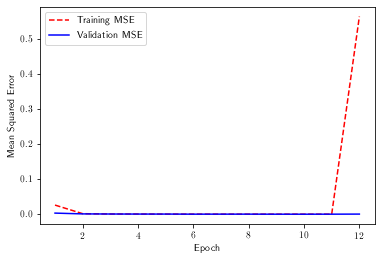

In [10]:
# Get training and test accuracy histories
training_mse = history.history['mean_squared_error']
validation_mse = history.history['val_mean_squared_error']

epoch_count = range(1, len(training_mse) + 1)
plt.plot(epoch_count, training_mse, 'r--')
plt.plot(epoch_count, validation_mse, 'b-')
plt.legend(['Training MSE', 'Validation MSE'])
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()

In [16]:
y_pred_keras = np.ravel(model.predict(x_test))*y_norm_factor
y_pred_keras = np.sqrt(y_pred_keras)

y_test = np.sqrt(y_test*y_norm_factor)

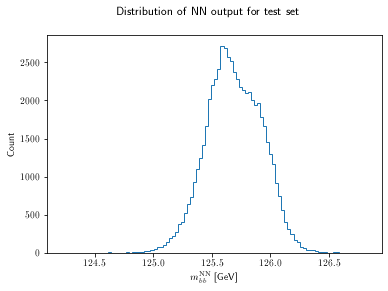

In [17]:
fig, ax = plt.subplots()
fig.suptitle("Distribution of NN output for test set")
n, bins, _ = ax.hist(y_pred_keras, histtype='step', align='mid', bins=100)
# plt.yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'$m_{bb}^\mathrm{NN}$ [GeV]')
ax.ticklabel_format(useOffset=False, style='plain')

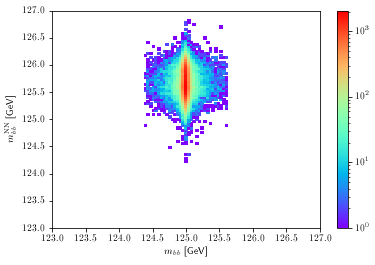

In [19]:
fig, ax = plt.subplots()
bins = np.linspace(123,127,100)
bx = np.linspace(np.min(y_test), np.max(y_test), 100)
by = np.linspace(np.min(y_pred_keras), np.max(y_pred_keras), 100)
n, bx, by, im = ax.hist2d(y_test, y_pred_keras, bins=[bins,bins], norm=colors.LogNorm(), cmap=cmap)
ax.set_xlabel(r'$m_{bb}$  [GeV]')
ax.set_ylabel(r'$m_{bb}^\mathrm{NN}$  [GeV]')
fig.colorbar(im, ax=ax)